In [46]:
!python -m pip install tensorflow_text

In [47]:


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from sklearn import feature_extraction, linear_model, model_selection, preprocessing

import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix


 

In [48]:
train=pd.read_csv('/content/drive/MyDrive/train.csv')
test=pd.read_csv('/content/drive/MyDrive/test.csv')


In [49]:
submission=pd.read_csv('/content/drive/MyDrive/submission.csv')

In [50]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [51]:
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [52]:
# substitue NaN value here with mode

#train['location'] = train['location'].fillna(train['location'].mode()[0])
#train['keyword'] = train['keyword'].fillna(train['keyword'].mode()[0])

#test['location'] = test['location'].fillna(test['location'].mode()[0])
#test['keyword'] = test['keyword'].fillna(test['keyword'].mode()[0])

In [53]:
#train.head(55)

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [56]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [57]:
test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [58]:
train.shape

(7613, 5)

In [59]:
test.shape

(3263, 4)

In [60]:
print(train.isnull().sum())  # Missing value in the training set

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [61]:
#Identify percentage of disaster tweets

train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [62]:
percentage_disaster=(train.target.value_counts() / len(train.target)) * 100
percentage_disaster

0    57.034021
1    42.965979
Name: target, dtype: float64

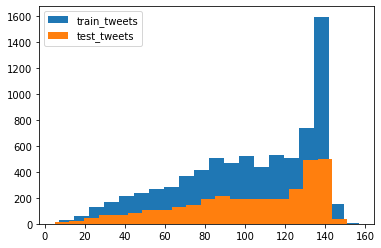

In [63]:
#compare tweets in train and test file

length_train=train['text'].str.len()
length_test=test['text'].str.len()
plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

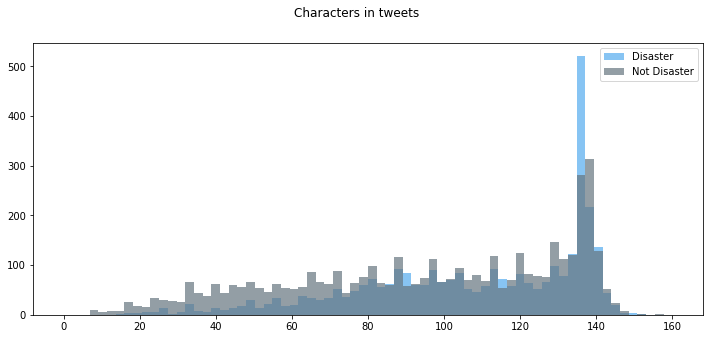

In [64]:
# tweet length

plt.figure(figsize=(12, 5))
plt.hist(train[train['target']==1]['text'].str.len(), 
         color='#55ACEE', alpha=0.7, bins=70, 
         range=(0, 160), label='Disaster')
plt.hist(train[train['target']==0]['text'].str.len(), 
         color='#66757F', alpha=0.7, bins=70, 
         range=(0, 160), label='Not Disaster')
plt.suptitle('Characters in tweets')
plt.legend()
plt.show()

In [65]:
countries = train["location"].value_counts().sort_values(ascending=False)
countries_df= pd.DataFrame(dict(zip(countries.index, countries.values)), index=[0]).\
                                melt(var_name="country", value_name="unique_counts")
# Note: Counts may not be accurate because not all area's have been replaced! 
countries_df.loc[:10]


data = {
    "locations": countries_df.loc[:10, "country"],
    "locationmode": "country names",
    "z": countries_df.loc[:10, "unique_counts"],
    "colorscale": "Rainbow",
    "text": countries_df.loc[:10, "country"],
    "type": "choropleth",
    "colorbar": {"title": "Unique Counts", "len": 200, "lenmode":"pixels"}
}

layout = go.Layout(title_text= "<b>Tweet Locations of top 10 Countries</b>",
                   geo= dict(scope= "world"))

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(title_x=0.5)
fig.show()

Data cleaning

In [66]:

def clean(text):
    text = re.sub(r"http\S+", " ", text) # remove urls
    text = re.sub(r"RT ", " ", text) # remove rt
    text = re.sub(r"[^a-zA-Z\'\.\,\d\s]", " ", text) # remove special character except # @ . ,
    text = re.sub(r"[0-9]", " ", text) # remove number
    text = re.sub(r'\t', ' ', text) # remove tabs
    text = re.sub(r'\n', ' ', text) # remove line jump
    text = re.sub(r"\s+", " ", text) # remove extra white space
    text = text.strip()
    return text


train.text = train.text.apply(clean)
test.text = test.text.apply(clean)

Vectorizing the sentences

In [67]:
X_train = []
for r in tqdm(train.text.values):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)
y_train = train.target.values

X_test = []
for r in tqdm(test.text.values):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 3263/3263 [03:12<00:00, 16.91it/s]


In [ ]:
train_arrays, test_arrays, train_labels, test_labels = train_test_split(X_train,y_train,test_size=0.05)

Training the model

In [ ]:
import time
start = time.process_time()

def svc_param_selection(X, y, nfolds):
    
    Cs = [1.070, 1.074, 1.075, 1.1, 1.125]
    #Cs = [0.001, 0.01, 0.1, 1, 10]
    #Cs = [0.01,0.01,0.1,1,10]
    #gammas = [0.001, 0.01, 0.1, 1]
    gammas = [2.065,2.075, 2.08]
    #gammas = [2.05,2.00,2.06]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds, n_jobs=8)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search

model = svc_param_selection(train_arrays,train_labels, 5)

print('Training time :', time.process_time() - start)

Best parameters

In [ ]:
model.best_params_

In [ ]:
pred = model.predict(test_arrays)

In [ ]:
cm = confusion_matrix(test_labels,pred)
cm

In [ ]:
clf = SVC(kernel='rbf')


# Fit data
clf = clf.fit(train_arrays, train_labels)
plot_confusion_matrix(clf,test_arrays,test_labels,cmap="Blues",values_format='d')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, pred))

In [ ]:


accuracy = accuracy_score(test_labels,pred)
print('Accuracy is:',+accuracy*100,'%')




In [ ]:
test_pred = model.predict(X_test)
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

In [ ]:
#Building Vectors
#Create instance

count_vectorizer = feature_extraction.text.CountVectorizer()

In [ ]:
#Fit Transform train data
train_vectors = count_vectorizer.fit_transform(train["text"])

In [ ]:
#Only transform test data - so that train and test use the same vectors
test_vectors = count_vectorizer.transform(test["text"])

In [ ]:
clf = linear_model.RidgeClassifier()

In [ ]:
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=3, scoring="f1")
scores.mean()

In [ ]:
clf.fit(train_vectors, train["target"])

In [ ]:
test['target'] = clf.predict(test_vectors)
submission.to_csv('submission1.csv', index=False)

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_arrays, train_labels)

#Predict the response for test dataset
y_pred = clf.predict(test_arrays)

In [ ]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy :",accuracy_score(test_labels, y_pred))

In [ ]:
clf = SVC(kernel='linear')


# Fit data
clf = clf.fit(train_arrays, train_labels)
plot_confusion_matrix(clf,test_arrays,test_labels,cmap="Accent",values_format='d')